# noise

purpose: high background noise degrades spike sorting. We characterized in vivo background noise and validated ours against in vivo's.

**in-vivo**:

* `Horvath`
    * rat
    * rectangular contact of 20 um side, see (2,3)
    * 128ch 
    * 20.0kHz
    * 3688.668s (1h)
    * "Spontaneous activity" (Only anesthetized condition)
    * questions: do we metadata for Horvath? were some of the contacts discarded?
    
**in-silico**:

* `Horvath`
    * rectangular contact of 20 um side, see (2,3)
    * 128ch 
    * 20.0kHz
    * 10 min
    * "Spontaneous activity"


### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.preprocessing as spre
import shutil 
import pandas as pd

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.prepro import preprocess
from src.nodes.dataeng.silico import recording


# SETUP PARAMETERS
GAIN = 1e5
# NOISE_STD = 3000
SFREQ = 20000       # sampling frequency
ENOISE = 5          # electronic noise of neuropixels (ultradense npx preprint)
AXON_NOISE = 5
WIND_END = 3700     # last segment to calculate mad
TARGET_SITE = 0


# horvath (vivo)
EXPERIMENT_h_vivo = "vivo_horvath"
SIMULATION_h_vivo = "probe_1" # TODO: change to probe_1
data_conf_h_vivo, param_conf_h_vivo = get_config(
    EXPERIMENT_h_vivo, SIMULATION_h_vivo
).values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_h_vivo = data_conf_h_vivo["postprocessing"]["trace_snr"]
CONTACTS_h = np.arange(0,128,1)

# HORVATH (silico)
EXPERIMENT_h_silico = "silico_horvath"
SIMULATION_h_silico = "concatenated/probe_1"
data_conf_h_silico, param_conf_h_silico = get_config(
    EXPERIMENT_h_silico, SIMULATION_h_silico
).values()
RAW_PATH_h_silico = data_conf_h_silico["recording"]["output"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_h_silico = data_conf_h_silico["postprocessing"]["trace_snr"]

2023-11-26 12:42:15,455 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-26 12:42:15,498 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-26 12:42:15,499 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-26 12:42:15,511 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Plot in vivo noise

“sources of electrical activity that might contribute to the noise power spec- trum, like electronic noise, axons, dendrites or synapse currents (Llinas, 1988; Farrant et al., 1994), was simulated by adding Gaus- sian noise” (Martinez et al., 2009, p. 287)

In [2]:
def plot_example_one_sec_segments(traces, target_site=0):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    winds = np.arange(0, 10, 1)
    for wind_i in winds:
        axes[wind_i].plot(traces[wind_i * 20000 : (wind_i + 1) * 20000, target_site])
        axes[wind_i].set_ylim([-200, 200])

    winds = np.arange(11, 21, 1)
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    ix = 0
    for wind_i in winds:
        axes[ix].plot(traces[wind_i * 20000 : (wind_i + 1) * 20000, target_site])
        axes[ix].set_ylim([-200, 200])
        ix += 1

    winds = np.arange(22, 32, 1)
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    ix = 0
    for wind_i in winds:
        axes[ix].plot(traces[wind_i * 20000 : (wind_i + 1) * 20000, target_site])
        axes[ix].set_ylim([-200, 200])
        ix += 1

    winds = np.arange(33, 43, 1)
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    ix = 0
    for wind_i in winds:
        axes[ix].plot(traces[wind_i * 20000 : (wind_i + 1) * 20000, target_site])
        axes[ix].set_ylim([-200, 200])
        ix += 1

    winds = np.arange(44, 54, 1)
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    ix = 0
    for wind_i in winds:
        axes[ix].plot(traces[wind_i * 20000 : (wind_i + 1) * 20000, target_site])
        axes[ix].set_ylim([-200, 200])
        ix += 1

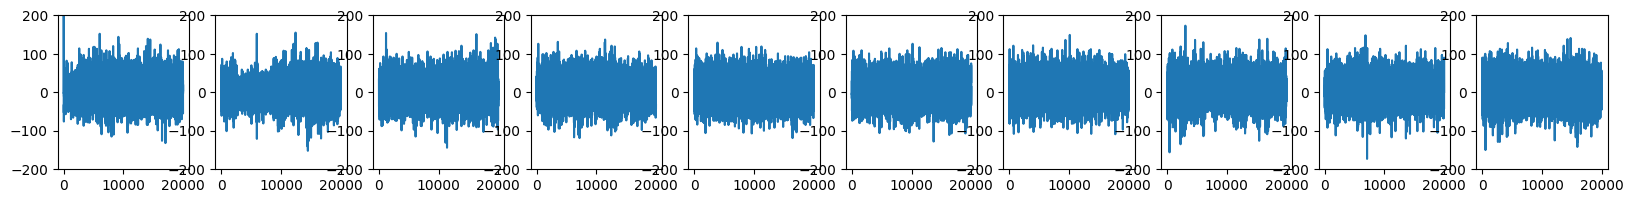

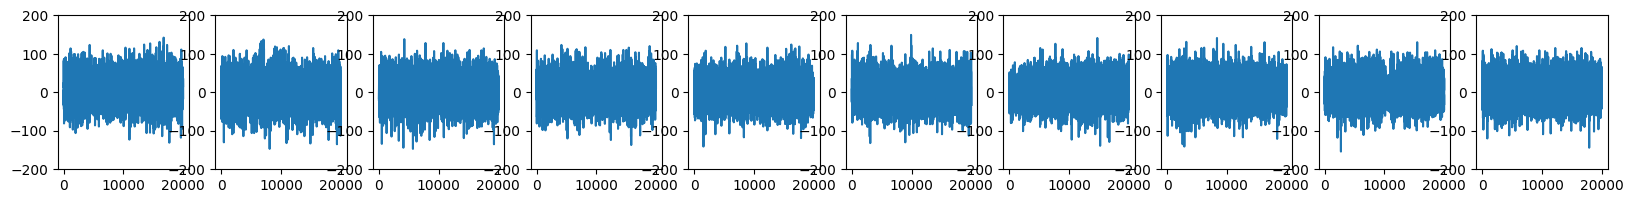

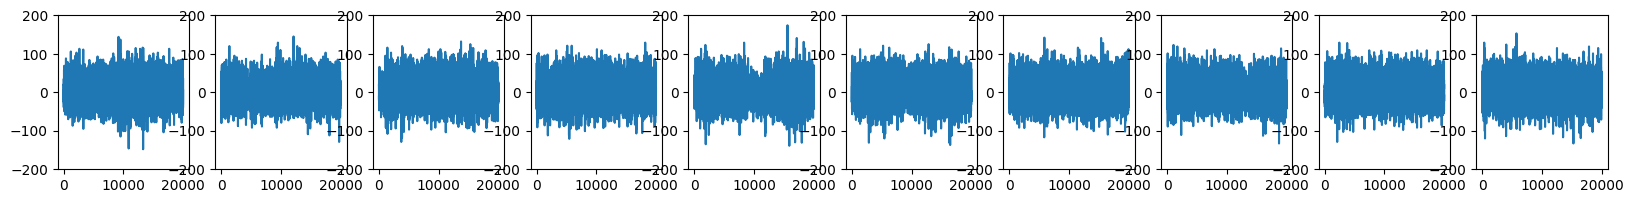

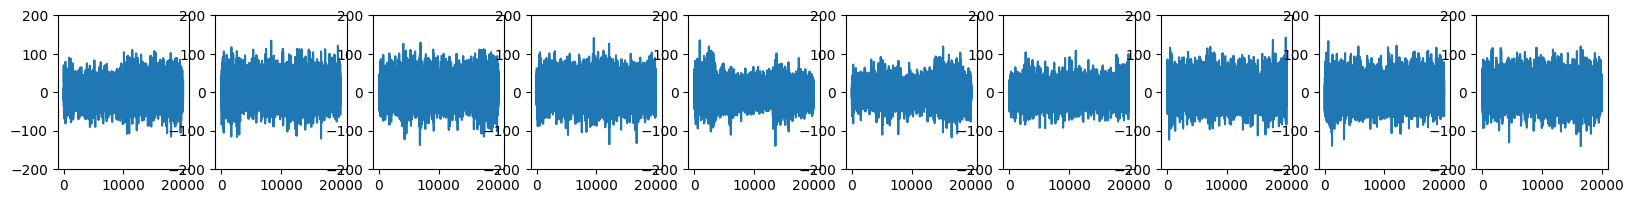

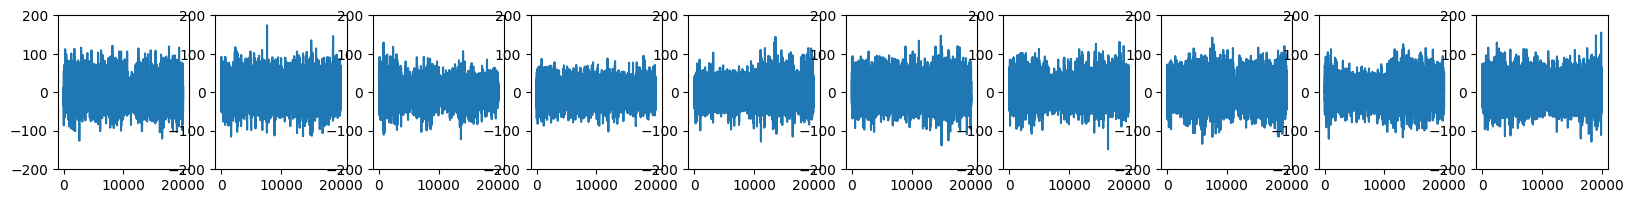

In [4]:
# plot example one-second segments of the trace
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces = PreRecording_h_vivo.get_traces()
plot_example_one_sec_segments(traces, target_site=0)

## 0. Check in vivo noise offset

* The mean was removed and the trace is centered around 0.
* So we removed the mean from each recording site.

In [5]:
# measure trace offset
np.mean(traces[:, TARGET_SITE])

-0.24346919162679478

## 1. Measuring in vivo noise

Background noise is the MAD of the segment with the smallest MAD (spikeless or nearly)

In [6]:
def measure_noise_at_consecutive_segs(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq, TARGET_SITE]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads

In [7]:
# takes 7 secs for entire recording
# mad is calculated for consecutive segments of 1 sec (SFREQ timepoints)
# mad is (df - df.mean()).abs().mean()
mads_vivo = measure_noise_at_consecutive_segs(traces, SFREQ, WIND_END)

/tmp/ipykernel_137385/3694713297.py:9: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mads.append(pd.DataFrame(segment).mad().values[0]);


## 2. Fit in silico noise

* MAD_vivo = scale * (MAD_silico + electronic_noise)
* We assume that the electronic noise is 5 uV on these electrodes (root mean squared = std as mean is about 0, Jennifer Colonell, see ultradense npx preprint) and set it to 5 uV as for neuropixels.
* `scale = MAD_vivo / (MAD_silico + electronic noise)`
* for detailed reasoning, see manuscript notes.

In [107]:
# fitted_silico_trace = (10000 * silico_traces) + ENOISE
# mads_fitted_silico = measure_noise_at_consecutive_segs(fitted_silico_trace, SFREQ, WIND_END)
# min(mads_fitted_silico)

/tmp/ipykernel_241247/3694713297.py:9: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mads.append(pd.DataFrame(segment).mad().values[0]);


7.247733494856485

In [54]:
np.random.seed(0)
adjust_to_match_vivo_noise = 0.7

# takes 50 secs

# fit model noise
# - calculate scaling factor to fit in silico noise to in vivo (minimum mad over trace's 1-sec segments)
# scale = (mad_vivo - 5) / mad_silico
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
silico_traces = PreRecording_h_silico.get_traces()

# measure raw in silico noise and fit model scale
mads_silico = measure_noise_at_consecutive_segs(silico_traces, SFREQ, WIND_END)

# find scale that fits silico noise to electronic-denoised in vivo noise
scale = min(mads_vivo) / (min(mads_silico) + ENOISE)
scale = scale + adjust_to_match_vivo_noise

# fit silico noise
ENOISE_RMS = 5  # standard deviation = RMS (mean is 0)
ENOISE_MEAN = 0
e_noise = np.random.normal(ENOISE_MEAN, ENOISE_RMS, [silico_traces.shape[0], 1])
fitted_silico_trace = scale * (silico_traces + e_noise)

# measure fitted in silico noise
mads_fitted_silico = measure_noise_at_consecutive_segs(
    fitted_silico_trace, SFREQ, WIND_END
)

# report
print(min(mads_vivo))
print(min(mads_fitted_silico))
print(scale)

/tmp/ipykernel_137385/3694713297.py:9: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mads.append(pd.DataFrame(segment).mad().values[0]);


13.959480239999998
13.72129476088723
3.491491408284391


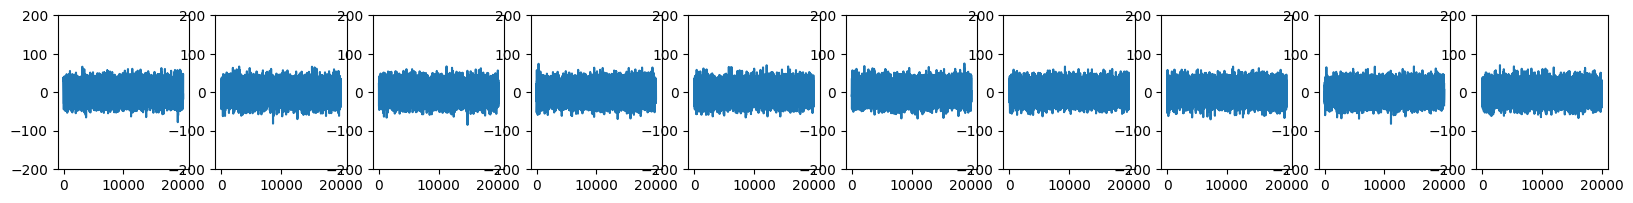

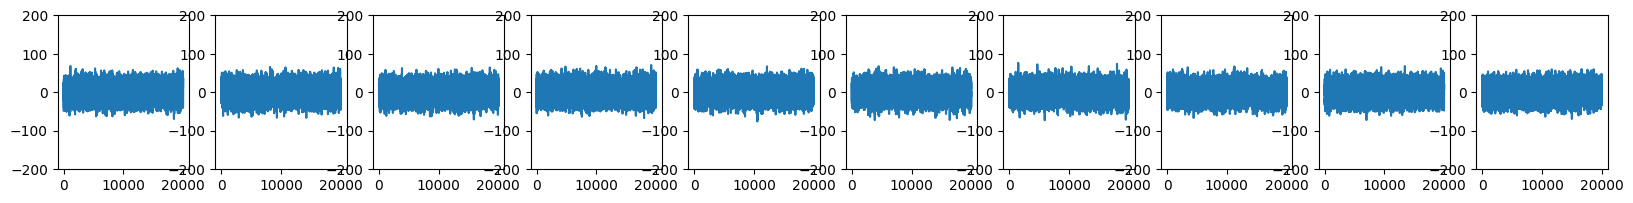

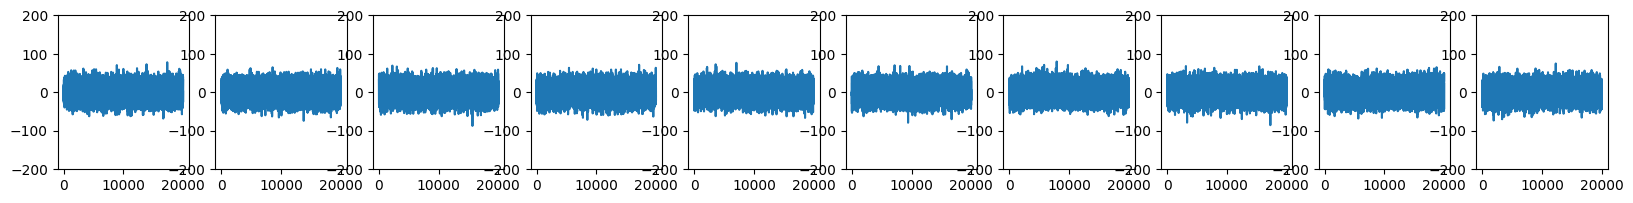

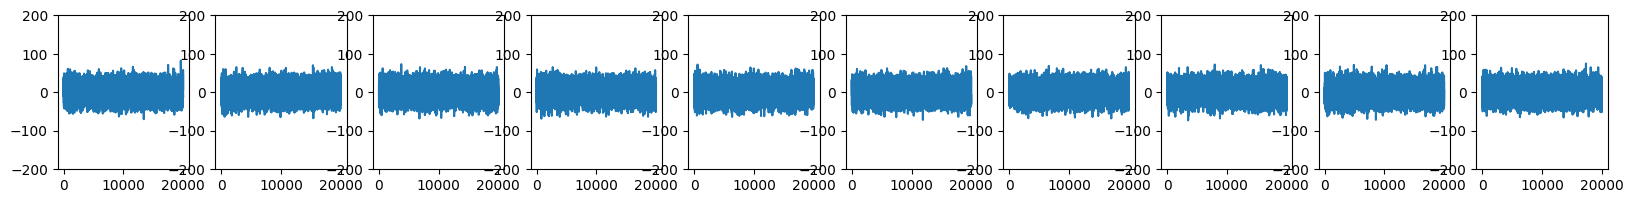

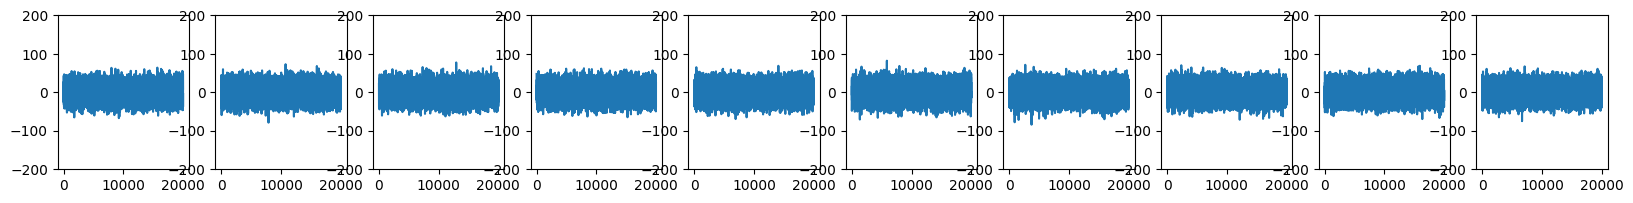

In [55]:
plot_example_one_sec_segments(fitted_silico_trace, target_site=0)

## 3. Plot noises


 Best estimate of in vivo noise (min mean abs. deviation): 13.959480239999998

 Best estimate of in silico noise (min mean abs. deviation): 13.72129476088723


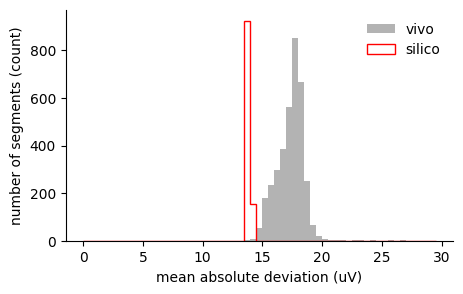

In [60]:
# hist vivo
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(mads_vivo, color=(0.7, 0.7, 0.7), label="vivo", bins=np.arange(0, 30, 0.5))
print("\n Best estimate of in vivo noise (min mean abs. deviation):", min(mads_vivo))

# hist silico
ax.hist(
    mads_fitted_silico,
    edgecolor="r",
    label="silico",
    histtype="step",
    bins=np.arange(0, 30, 0.5),
)
print(
    "\n Best estimate of in silico noise (min mean abs. deviation):",
    min(mads_fitted_silico),
)

# legend
ax.set_ylabel("number of segments (count)")
ax.set_xlabel("mean absolute deviation (uV)")
ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)

# save figure
plt.savefig("figures/2_realism/2_noise/noise_horv_vs_fitted_model.pdf")
plt.savefig("figures/2_realism/2_noise/noise_horv_vs_fitted_model.svg")